In [1]:
#suppress warnings
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import tqdm
import timeit
import PIL.Image
import pickle
import seaborn as sns
import gc
import cv2
import keras

from keras.models import Model, Input
from keras.layers import Activation, Concatenate, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.initializers import RandomNormal
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.initializers import RandomNormal
from skimage.transform import resize

%matplotlib inline

Using TensorFlow backend.


In [3]:
IM_HEIGHT = 137
IM_WIDTH = 236

In [4]:
class_map_df = pd.read_csv("class_map.csv")

In [5]:
class_map_df.component_type.value_counts()

grapheme_root          168
vowel_diacritic         11
consonant_diacritic      7
Name: component_type, dtype: int64

In [6]:
#The above forms the roots of the classifaction tree head

In [7]:
train_csv = pd.read_csv("train.csv")

In [8]:
len(train_csv)

200840

In [9]:
train_csv.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


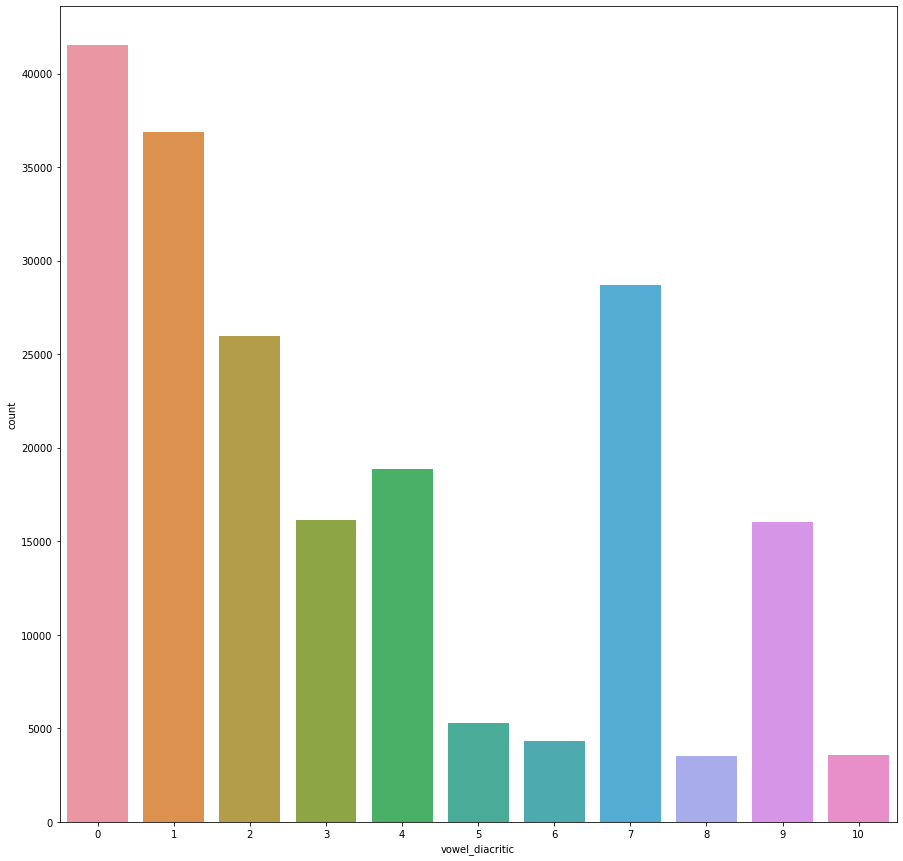

In [10]:
plt.figure(figsize=(15,15))
sns.countplot(train_csv["vowel_diacritic"])

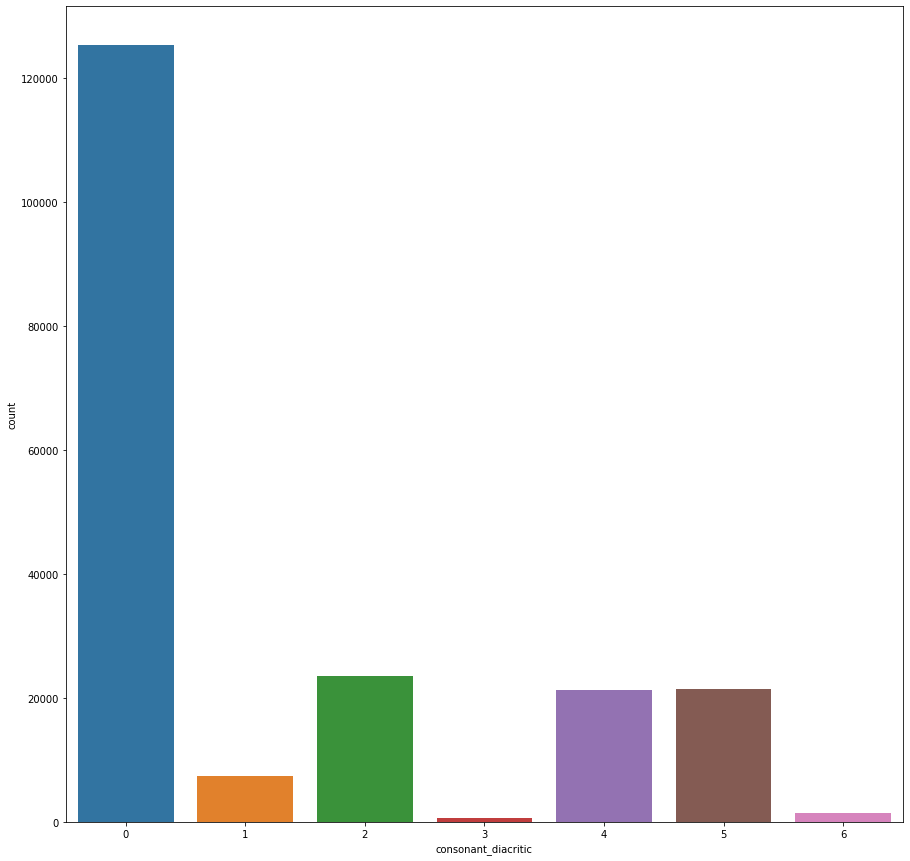

In [11]:
plt.figure(figsize=(15,15))
sns.countplot(train_csv["consonant_diacritic"])

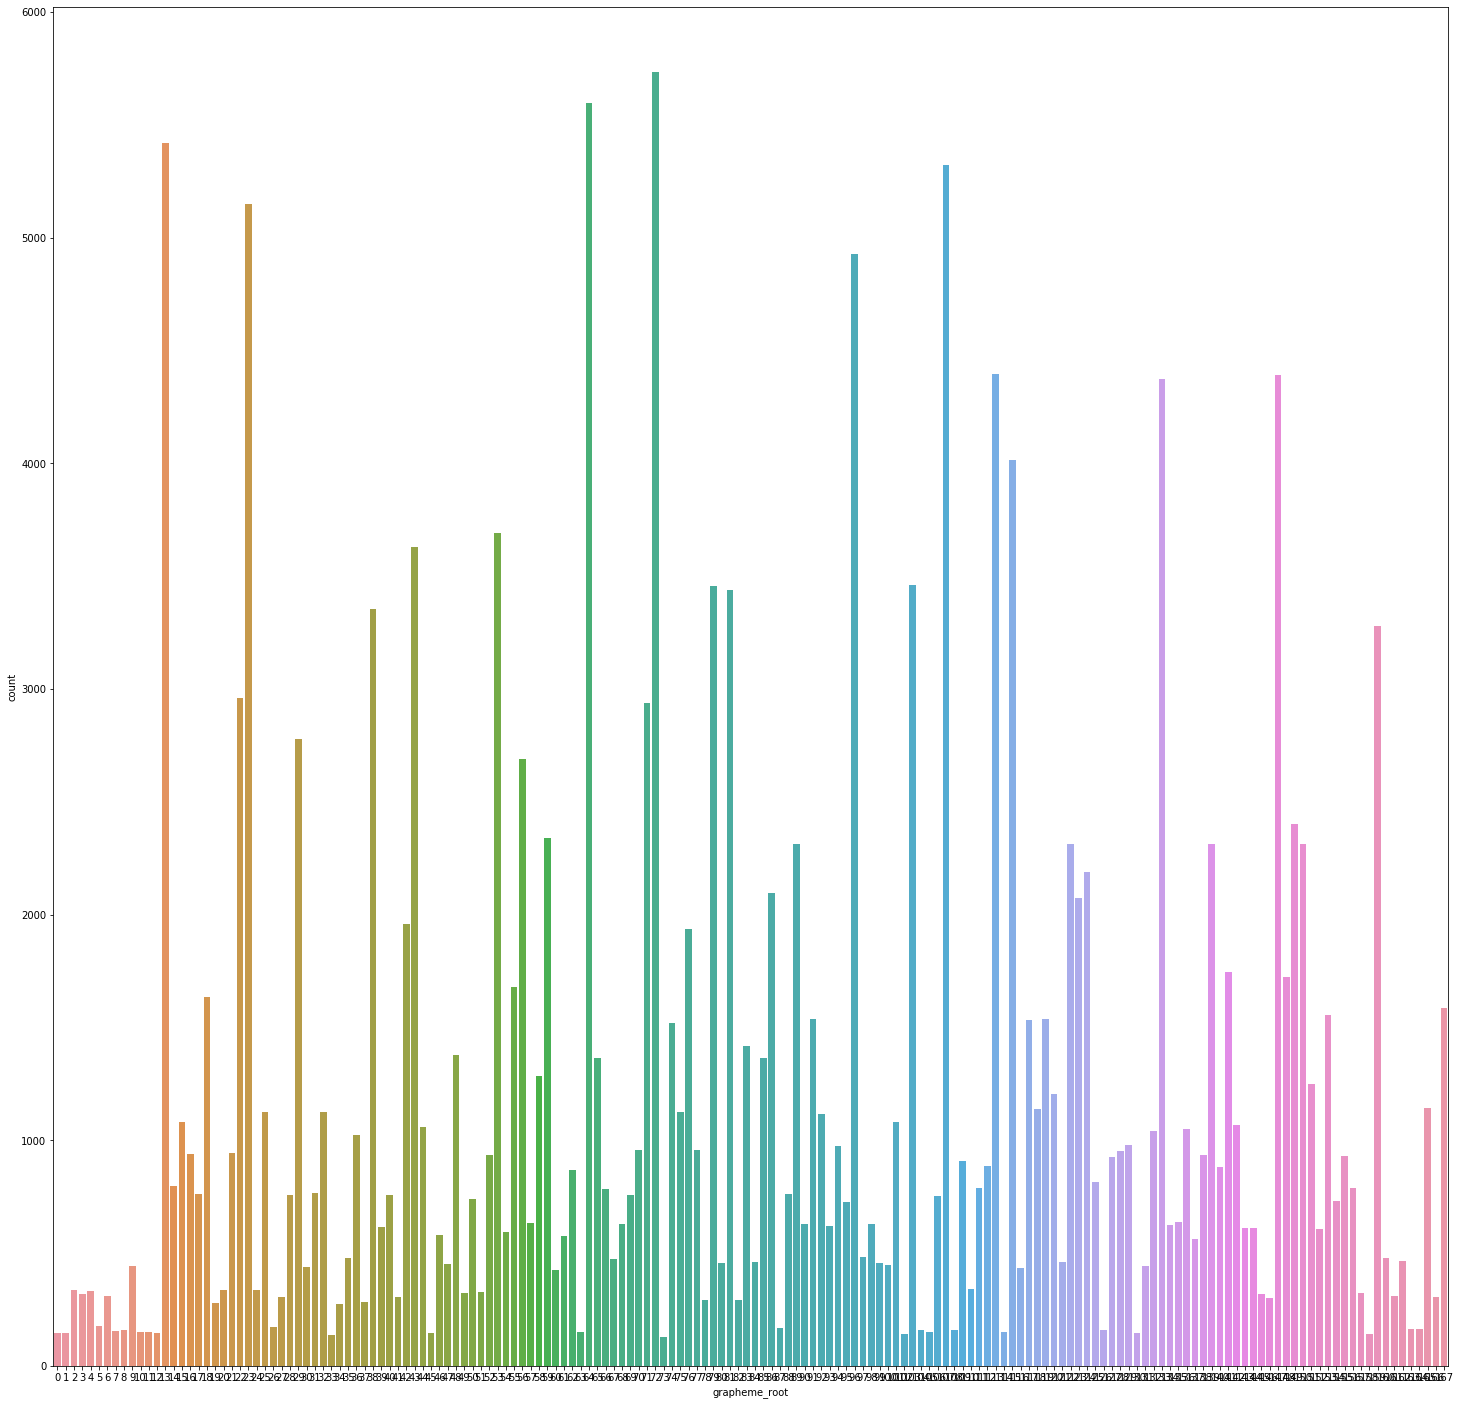

In [12]:
plt.figure(figsize=(25,25))
sns.countplot(train_csv["grapheme_root"])

In [13]:
def get_train_test_files():
    train_files =[]
    test_files = []
    for name in os.listdir():
        if name.split(".")[-1] == "parquet":
            if name.split("_")[0] == "train":
                train_files.append(name)
            else:
                test_files.append(name)
    train_files.sort()
    test_files.sort()
    return train_files, test_files

In [14]:
def test_train_files():
    train_files, test_files = get_train_test_files()
    print(train_files)
    print(test_files)

In [15]:
test_train_files()

['train_image_data_0.parquet', 'train_image_data_1.parquet', 'train_image_data_2.parquet', 'train_image_data_3.parquet']
['test_image_data_0.parquet', 'test_image_data_1.parquet', 'test_image_data_2.parquet', 'test_image_data_3.parquet']


In [16]:
def load_train_data():
    train_files, test_files = get_train_test_files()
    mast_train = pd.DataFrame()
    for parfile in train_files:
        print(parfile)
        train_parqutet = pd.read_parquet(parfile)
        mast_train = mast_train.append(train_parqutet)
    #print (mast_train.)
    return mast_train

def load_test_data():
    train_files, test_files = get_train_test_files()
    mast_test = pd.DataFrame()
    for parfile in test_files:
        print(parfile)
        test_parqutet = pd.read_parquet(parfile)
        mast_test = mast_test.append(test_parqutet)
    #print (mast_train.)
    return mast_test

In [5]:
def ser_df_frame(df, fname):
    with open(fname, "wb") as output_file:
        pickle.dump(df, output_file,protocol=4)
        
def load_pickle_data(fname):
    with open(fname, "rb") as input_file:
        df = pickle.load(input_file)
    return df

In [19]:
#all_train_df = load_train_data()

In [20]:
#ser_train_frame(all_train_df, "train_file_v1.pkl")

In [21]:
#all_test_df = load_test_data()
#ser_train_frame(all_test_df, "test_file_v1.pkl")

In [10]:
all_test_df = load_pickle_data("test_file_v1.pkl")
all_train_data_df = load_pickle_data("train_file_v1.pkl")


In [8]:
def collect_gc():
    gc.collect()

In [9]:
collect_gc()

In [6]:
def display_images(train_parqutet,train_csv, num_images=10):
    plt.figure()
    fig, ax = plt.subplots(5,5,figsize=(12,12))
    for imageid in range(num_images):
        #print(imageid)
        image_rec = train_parqutet.iloc[imageid]
        image_id = image_rec["image_id"]
        #print (image_id)
        image_i = image_rec.drop("image_id") 
        img_arr = np.array(image_i).reshape(137,236).astype("float32")
        train_csv_rec = train_csv.loc[train_csv["image_id"] == image_id]
        img = PIL.Image.fromarray(img_arr)
        #print(imageid//5, imageid%5)
        ax[imageid//5, imageid%5].imshow(img)
        ax[imageid//5, imageid%5].set_title(str(np.array(train_csv_rec["image_id"])[0]))
        ax[imageid//5, imageid%5].axis("off")
        
    
    

<Figure size 432x288 with 0 Axes>

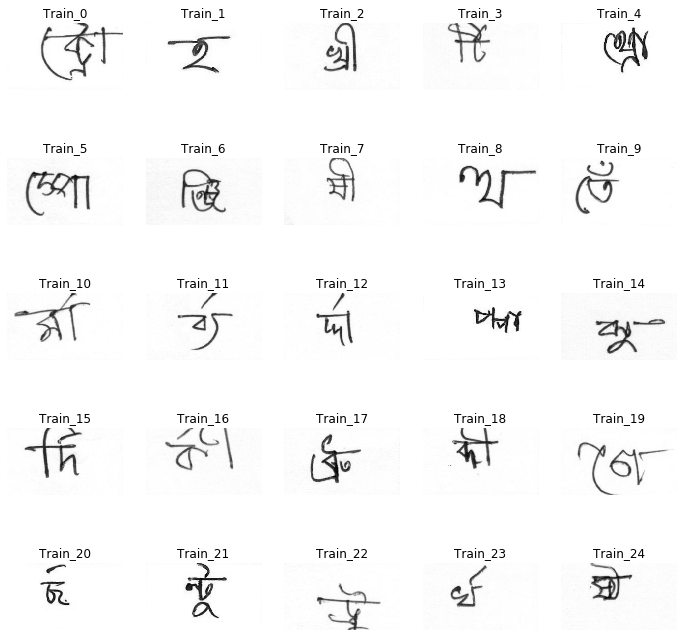

In [24]:
display_images(all_train_data_df,train_csv, 25)

In [83]:
#ser_df_frame(train_df,"merged_df.pkl")

In [37]:
all_train_data_df.drop(columns=["image_id"], inplace=True)

In [38]:
all_train_data_df

,0,1,2,3,4,5,6,7,8,9,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,254,253,252,253,251,252,253,251,251,253,...,253,253,253,253,253,253,253,253,253,251
1,251,244,238,245,248,246,246,247,251,252,...,255,255,255,255,255,255,255,255,255,254
2,251,250,249,250,249,245,247,252,252,252,...,254,253,252,252,253,253,253,253,251,249
3,247,247,249,253,253,252,251,251,250,250,...,254,254,254,254,254,253,253,252,251,252
4,249,248,246,246,248,244,242,242,229,225,...,255,255,255,255,255,255,255,255,255,255
5,251,251,252,253,251,249,248,248,249,249,...,252,251,252,252,252,253,253,252,251,250
6,238,236,234,235,238,242,241,237,230,229,...,251,251,253,254,254,253,252,251,252,253
7,250,251,252,252,252,252,252,252,252,252,...,253,254,254,253,253,253,253,253,251,251
8,251,252,251,253,254,253,254,253,254,253,...,253,253,253,253,253,253,253,253,253,252
9,251,249,252,253,253,253,253,253,253,252,...,253,253,253,252,253,253,253,253,252,252


In [7]:
collect_gc()

NameError: name 'collect_gc' is not defined

In [11]:
train_gf = pd.merge(train_csv, all_train_data_df, on="image_id")

In [14]:
y_grapheme_root = train_gf["grapheme_root"]
y_vowel_diatric = train_gf["vowel_diacritic"]
y_consonant_diatric = train_gf["consonant_diacritic"]

In [15]:
def reshape_array(df):
    X_train = np.array(df,dtype="float32")
    X_train = X_train.reshape(len(df), IM_HEIGHT,IM_WIDTH)
    return X_train

In [40]:
#X_train = reshape_array(all_train_data_df)

In [46]:
#del all_train_data_df,
del all_test_df

In [47]:
collect_gc()

In [16]:
#load_pickle_data(fname)

#ser_df_frame(X_train,"images_all.pkl")
#ser_df_frame(y_grapheme_root,"y_grapheme.pkl")
#ser_df_frame(y_vowel_diatric,"y_vowel_diatric.pkl")
#ser_df_frame(y_consonant_diatric,"y_consonant_diatric.pkl")

In [43]:
y_grapheme_root = load_pickle_data("y_grapheme.pkl")
y_vowel_diatric = load_pickle_data("y_vowel_diatric.pkl")
y_consonant_diatric = load_pickle_data("y_consonant_diatric.pkl")

In [5]:
X_train = load_pickle_data("images_all.pkl")

In [68]:
IMG_SIZE = 128
inputs = Input(shape = (IMG_SIZE, IMG_SIZE,1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', 
               input_shape=(IMG_SIZE, IMG_SIZE,1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])



In [69]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 128, 128, 32) 320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_51[0][0]                  
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_52[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [ ]:
model.compile()

In [8]:
import cv2

In [37]:
img = X_train[0]

NameError: name 'X_train' is not defined

In [10]:
img = img.astype("float32")
#img = PIL.Image.fromarray(img)imb

In [11]:
img.shape

(137, 236)

In [12]:
demo = PIL.Image.fromarray(img)

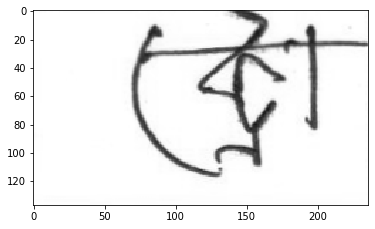

In [13]:
plt.imshow(demo)

In [14]:
img2 = cv2.resize(img,(128,128))

In [15]:
img2.shape

(128, 128)

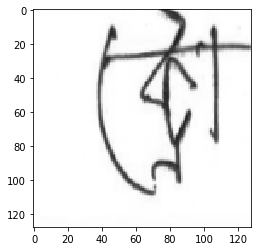

In [16]:
demo = PIL.Image.fromarray(img2)
plt.imshow(demo)

In [17]:
img = X_train[2]

bottle_resized = resize(img.astype("float32"), (128, 128))

In [18]:
bottle_resized
bottle_resized.shape

(128, 128)

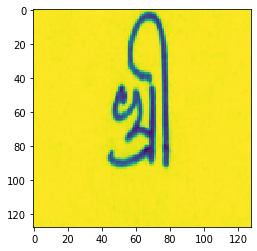

In [19]:
plt.imshow(bottle_resized)

In [29]:
def resize_images(X_train):
    resized_img = {}
    for i in range(len(X_train)):
        img =  X_train[i]
        #print (img.shape)
        img = resize(img.astype("float32"), (128,128))
        resized_img[i] = img
    return resized_img

In [ ]:
X_train_updated = resize_images(X_train)

In [13]:
!ls

Bengali Graphene.ipynb	test_image_data_0.parquet   train_image_data_1.parquet
class_map.csv		test_image_data_1.parquet   train_image_data_2.parquet
images_all.pkl		test_image_data_2.parquet   train_image_data_3.parquet
merged_df.pkl		test_image_data_3.parquet   X_train_resizwed.pkl
sample_submission.csv	train.csv		    y_consonant_diatric.pkl
test.csv		train_file.pkl		    y_grapheme.pkl
test_file.pkl		train_file_v1.pkl	    y_vowel_diatric.pkl
test_file_v1.pkl	train_image_data_0.parquet


In [14]:
y_grapheme_root = load_pickle_data("y_grapheme.pkl")
y_vowel_diatric = load_pickle_data("y_vowel_diatric.pkl")
y_consonant_diatric = load_pickle_data("y_consonant_diatric.pkl")

In [15]:
x_train, x_test, y_train_root,y_test_root,y_train_vowel, y_test_vowel, y_train_consonants, y_test_consonants = train_test_split(X_train_updated, y_grapheme_root,y_vowel_diatric,y_consonant_diatric, test_size=0.1, random_state=42)  

In [16]:
len(x_train), len(y_train_root)

(180756, 180756)

In [56]:
#ser_df_frame(X_train_updated,"X_train_resizwed.pkl")

In [11]:
X_train_updated = load_pickle_data("X_train_resizwed.pkl")

In [17]:
for i in range(len(x_train)):
    x_train[i] = x_train[i]/255. 

In [89]:
#y_grapheme_root = keras.utils.to_categorical(y_grapheme_root, 168)

In [18]:
y_train_root = keras.utils.to_categorical(y_train_root, 168)

In [19]:
y_train_consonants = keras.utils.to_categorical(y_train_consonants, 7)

In [20]:
y_train_vowel = keras.utils.to_categorical(y_train_vowel,11)

In [21]:
del X_train_updated
collect_gc()

In [23]:
len(y_train_root)

180756

In [26]:
# Callback : Learning Rate annealer
reduceLR = ReduceLROnPlateau(monitor = 'val_root_loss',
                             patience = 2,
                             factor = 0.5,
                             min_lr = 1e-5,
                             verbose = 1)
# Callback : Save best model
chkPoint = ModelCheckpoint('dense.h5',
                           monitor = 'val_root_accuracy',
                           save_best_only = True,
                           save_weights_only = False,
                           mode = 'auto',
                           period = 1,
                           verbose = 0)
# Callback : Early Stop
earlyStop = EarlyStopping(monitor='val_root_accuracy',
                          mode = 'auto',
                          patience = 4,
                          min_delta = 0,
                          verbose = 1)

In [37]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [71]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
x_train_1 = np.array(x_train)

In [57]:
#x_test_1 = np.array(x_test)
z1=x_test_1.reshape(x_test_1.shape[0],128,128,1)

In [53]:
z =x_train_1.reshape(x_train_1.shape[0],128,128,1)

In [56]:
z.shape

(180756, 128, 128, 1)

In [79]:
type(z)

numpy.ndarray

In [73]:
epochs=30
batch_size=128
history = model.fit(z,
                    {'dense_23': y_train_root, 'dense_24': y_train_vowel, 'dense_25': y_train_consonants},
                    batch_size = batch_size,
                    epochs = epochs,
                    shuffle = True,
                    validation_data = (z1,
                                       {'dense_23': y_test_root,
                                        'dense_24': y_test_vowel,
                                        'dense_25': y_test_consonants}),
                    callbacks = [reduceLR, chkPoint, earlyStop],
                    verbose = 1)

    #del x_train, x_test, y_train, y_test
    #gc.collect()

ValueError: Error when checking target: expected dense_23 to have shape (168,) but got array with shape (1,)

In [40]:
test =x_train[:10]

In [42]:
z =np.array(test)

In [43]:
z.shape

(10, 128, 128)